In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize
from itertools import combinations

def get_psd(raw, filter=None, returnMean=False):
    raw_copy = raw.copy()
    if(filter != None):
        raw_copy.filter(filter[0],filter[1], verbose=False)
    psd, freq = mne.time_frequency.psd_welch(raw_copy,n_fft = raw_copy.data.shape[1], verbose=False)
    psd = 10 * np.log10(psd)
    if(returnMean):
        psd = psd.mean(axis=1)
        if(np.any(np.isnan(psd))):
            raise ValueError(f"value NaN: {psd}")
        if(np.all(np.isfinite(psd)) == False):
            raise ValueError(f"value inifinit: {psd}")
    mean = psd.mean(0)
    std = psd.std(0)
    return psd, freq, mean, std

def get_epoch(raw, verbose=False):
    raw_copy = raw.copy()
    events = mne.find_events(raw_copy, stim_channel='Marker', initial_event=True, verbose=verbose)
    if(len(events) != 5):
        raise ValueError(f"The event is missing. Number of event not equal to 5 ({len(events)}).\n {events}")
    epochs = mne.Epochs(raw_copy, events, tmin=0.3, tmax=5.5, baseline=(0.3,0.3), verbose=verbose)
    if(epochs.get_data().shape[0] != 5):
        raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")
    return epochs

def plot_psd(raw):
    psd, freq, mean, std = get_psd(raw)
    fig, ax = plt.subplots(figsize=(10,5))
    for i in range(8):
        ax.plot(freq,psd[i] ,label=raw.info['ch_names'][i], lw=1, alpha=0.6)
    ax.fill_between(250//2, mean - std, mean + std, color='k', alpha=.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitube (dBV)')
    ax.set_title('EEG of ')
    ax.legend()
    plt.show()

In [2]:
# !pip3 list | grep mne

## Groud Truth

In [3]:
plt.style.use('seaborn-whitegrid')

df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
labels = []
for i in gt.index:
    # print(gt.loc[i], np.argmax(gt[['h','e','x','a','c','o']].loc[i]))
    labels.append(np.argmax(gt[['h','e','x','a','c','o']].loc[i]))
gt['label'] = labels
gt

,h,e,x,a,c,o,label
id,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,0
3,3.38,3.44,3.50,3.50,4.50,3.81,4
4,3.19,3.75,3.69,3.19,2.63,2.63,1
5,3.25,3.63,2.13,3.56,3.63,2.31,1
6,3.25,2.75,3.50,2.50,3.75,5.00,5
7,4.06,3.06,3.38,2.88,2.50,4.19,5
8,3.94,2.94,3.19,3.75,3.38,3.81,0
9,4.44,4.00,3.38,3.75,3.69,3.31,0
10,3.63,3.25,3.50,3.31,3.88,2.69,4


## EEG Data

In [4]:
path, folders, filenames = next(walk('./data'))
print(filenames)

['29-audio.csv', '5-audio.csv', '10-audio.csv', '17-audio.csv', '10-image.csv', '14-audio.csv', '33-audio.csv', '31-audio.csv', '9-audio.csv', '20-audio.csv', '6-audio.csv', '13-image.csv', '25-image.csv', '5-image.csv', '14-image.csv', '22-image.csv', '7-image.csv', '23-audio.csv', '28-image.csv', '15-audio.csv', '25-audio.csv', '32-audio.csv', '21-image.csv', '23-image.csv', '2-audio.csv', '36-audio.csv', '26-audio.csv', '12-audio.csv', '3-image.csv', '2-image.csv', '35-image.csv', '12-image.csv', '30-image.csv', '36-image.csv', '27-audio.csv', '15-image.csv', '32-image.csv', '26-image.csv', '8-audio.csv', '34-image.csv', '8-image.csv', '20-image.csv', '9-image.csv', '3-audio.csv', '35-audio.csv', '16-audio.csv', '22-audio.csv', '17-image.csv', '7-audio.csv', '11-audio.csv', '18-image.csv', '27-image.csv', '29-image.csv', '13-audio.csv', '6-image.csv', '30-audio.csv', '21-audio.csv', '31-image.csv', '33-image.csv', '34-audio.csv', '28-audio.csv', '11-image.csv', '16-image.csv', '18-a

In [5]:
gt.drop([11,4,36],inplace=True)

filenames.remove('11-audio.csv')
filenames.remove('11-image.csv')

filenames.remove('36-audio.csv')
filenames.remove('36-image.csv')

In [6]:
path = './data'
columns = {'Unnamed: 1':'Fp1',
        'Unnamed: 2':'Fp2',
        'Unnamed: 3':'F3',
        'Unnamed: 4':'F4',
        'Unnamed: 5':'F7',
        'Unnamed: 6':'F8',
        'Unnamed: 7':'P7',
        'Unnamed: 8':'P8'}

EEG_audio, EEG_image = dict(), dict()
from itertools import product
categories = [1,2,3,4,5]
blocks = [1,2]
for filename in filenames:
    participant_id, stimuli = filename.split('-')
    stimuli = stimuli.rstrip('.csv')
    data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
    print(participant_id, stimuli)
    # experiment = dict()
    # for (category, block) in product(categories,blocks):
        # print("   ", category, block)
        # section = get_section_from_catblock(data, category=category,block=block)
        # experiment[f"{category}_{block}"] = section
    if(stimuli == 'audio'):
        EEG_audio[int(participant_id)] = data
    elif(stimuli == 'image'):
        EEG_image[int(participant_id)] = data
    else:
        raise ValueError(f"Stimuli:{stimuli} is unexpected.")

29 audio
5 audio
10 audio
17 audio
10 image
14 audio
33 audio
31 audio
9 audio
20 audio
6 audio
13 image
25 image
5 image
14 image
22 image
7 image
23 audio
28 image
15 audio
25 audio
32 audio
21 image
23 image
2 audio
26 audio
12 audio
3 image
2 image
35 image
12 image
30 image
27 audio
15 image
32 image
26 image
8 audio
34 image
8 image
20 image
9 image
3 audio
35 audio
16 audio
22 audio
17 image
7 audio
18 image
27 image
29 image
13 audio
6 image
30 audio
21 audio
31 image
33 image
34 audio
28 audio
16 image
18 audio


In [7]:
def get_data(eeg_type = 'image', bands = [0,1,2,3,4]):
    X = []
    y = []
    # Gamma BETA ALPHA THETA DELTA
    filter_list = [[30,None],[13,30],[8,12],[4,8],[None,4]]
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in ids:
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)
        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")
        
        for epoch in epochs.iter_evoked():
            features = []
            for band in bands:
                # print(epoch.data.shape)
                psd,_,_,_ = get_psd(epoch, filter=filter_list[band], returnMean=True)
                features.append(psd)
                # print(psd,filter_list[band])
            # # Gamma (> 30 Hz) 
            # gamma_psd,_,_,_ = get_psd(epoch, filter=[30,None], returnMean=True)
            # # BETA (13-30 Hz)
            # beta_psd,_,_,_ = get_psd(epoch, filter=[13,30], returnMean=True)
            # # ALPHA (8-12 Hz)
            # alpha_psd,_,_,_ = get_psd(epoch, filter=[8,12], returnMean=True)
            # # THETA (4-8 Hz)
            # thata_psd,_,_,_ = get_psd(epoch, filter=[4,8], returnMean=True)
            # # DELTA (< 4 Hz).
            # delta_psd,_,_,_ = get_psd(epoch, filter=[None,4], returnMean=True)
            # print(gamma_psd.shape,beta_psd.shape,alpha_psd.shape,thata_psd.shape,delta_psd.shape)
            # bands = np.array([gamma_psd,beta_psd,alpha_psd,thata_psd,delta_psd]).reshape(-1)
            X.append(np.array(features).reshape(-1))
            y.append(gt.loc[id]['label'])
        # break
    X = np.array(X)#.reshape(len(ids),-1)
    y = np.array(y)
    return X,y
# X,y = get_data()

def get_acc(X,y):
    X_norm = normalize(X)
    gnb = GaussianNB()
    gnb.fit(X_norm, y)  
    pred = gnb.predict(X_norm)
    acc = sum(y == pred)/len(y)
    return acc

In [8]:
# import warnings
# warnings.filterwarnings("ignore")
# band_name = np.array(['Gamma','BETA','ALPHA','THETA','DELTA'])

In [9]:
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs, read_ica, find_eog_events
raw = dataframe_to_raw(EEG_image[33], sfreq=250)
filt_raw = raw.copy().filter(l_freq=1., h_freq=None).notch_filter([50,100])

In [10]:
ica = ICA(n_components=8, max_iter='auto', random_state=97)
ica.fit(filt_raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 1.3s.


<ICA | raw data decomposition, fit (fastica): 116976 samples, 8 components, channels used: "eeg">

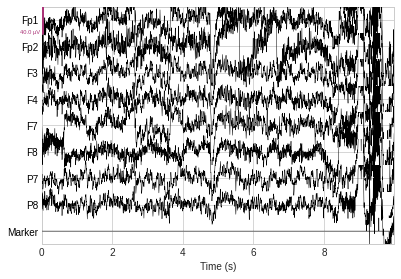

Creating RawArray with float64 data, n_channels=8, n_times=116976
    Range : 0 ... 116975 =      0.000 ...   467.900 secs
Ready.


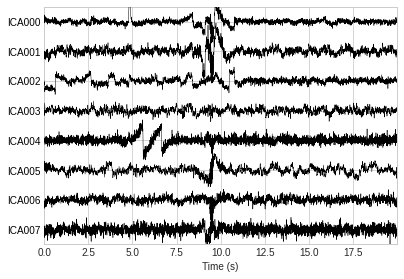

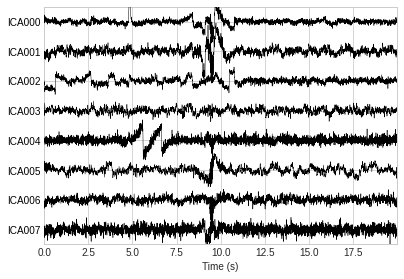

In [11]:
filt_raw.plot(show_scrollbars=False)
ica.plot_sources(filt_raw, show_scrollbars=False)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


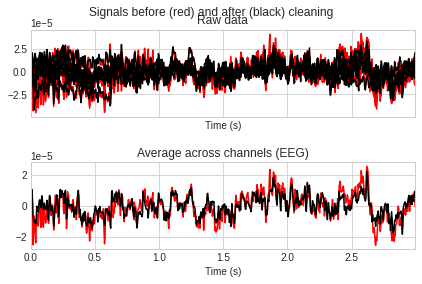

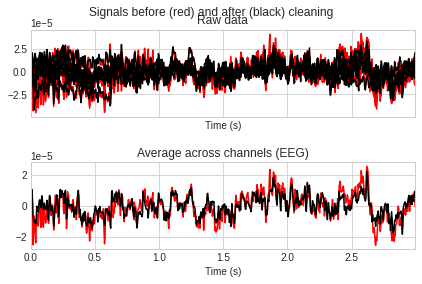

In [12]:
ica.plot_overlay(filt_raw, exclude=[0], picks='eeg')

In [21]:
ica.exclude = [0, 1]
reconst_raw = raw.copy().filter(l_freq=1., h_freq=None).notch_filter([50,100])
# ica.apply(reconst_raw)

In [22]:
reconst_raw = ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


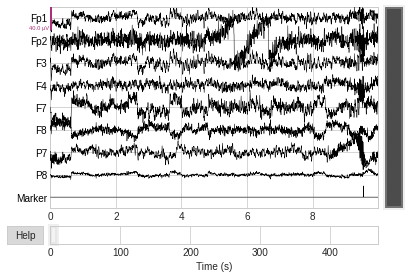

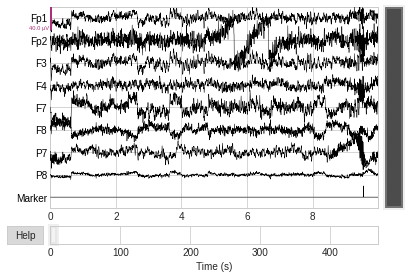

In [23]:
reconst_raw.plot()

In [ ]:
raw = dataframe_to_raw(EEG_image[33], sfreq=250)
raw_filt = raw.copy().filter(l_freq=1., h_freq=None).notch_filter([50,100])
ica = ICA(n_components=8, method='fastica', max_iter="auto").fit(raw_filt)

In [ ]:
eog_epochs = create_eog_epochs(raw_filt, ch_name=['Fp1', 'Fp2'])
# eog_epochs

In [ ]:
eog_inds, scores = ica.find_bads_eog(eog_epochs, threshold=0.0, ch_name=['Fp1','Fp2'])

In [ ]:
ica.plot_sources(raw_filt, picks=eog_inds)

In [ ]:
find_eog_events(raw, ch_name=['Fp1', 'Fp2'])